## Import

In [1]:
import math
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import clear_output

import nibabel as nib
from nibabel.brikhead import *

from nilearn import plotting

### Load Subject

In [2]:
sub_id = 2
sub_id = f'{str(sub_id).zfill(2)}'

dir_sub_id = f'./data/s{sub_id}/ad_lh_rh_vs/s{sub_id}.results/*.brik'

In [3]:
glob(dir_sub_id)

['./data/s02/ad_lh_rh_vs/s02.results\\pb02.s02.r01.blur+tlrc.BRIK',
 './data/s02/ad_lh_rh_vs/s02.results\\pb02.s02.r02.blur+tlrc.BRIK',
 './data/s02/ad_lh_rh_vs/s02.results\\pb02.s02.r03.blur+tlrc.BRIK',
 './data/s02/ad_lh_rh_vs/s02.results\\pb02.s02.r04.blur+tlrc.BRIK']

In [4]:
fname = glob(dir_sub_id)[0]
ad_raw_brik = nib.load(fname)
ad_img_brik = ad_raw_brik.get_fdata()

In [5]:
fname = glob(dir_sub_id)[1]
lh_raw_brik = nib.load(fname)
lh_img_brik = lh_raw_brik.get_fdata()

In [6]:
fname = glob(dir_sub_id)[2]
rh_raw_brik = nib.load(fname)
rh_img_brik = rh_raw_brik.get_fdata()

In [7]:
fname = glob(dir_sub_id)[3]
vs_raw_brik = nib.load(fname)
vs_img_brik = vs_raw_brik.get_fdata()

### Load all the subjects and Average

In [8]:
avg_ad, avg_lh, avg_rh, avg_vs = 0, 0, 0, 0
num_subs = len(range(2, 14))
for sub_id in range(2, 14):
    sub_id = f'{str(sub_id).zfill(2)}'
    dir_sub_id = glob(f'./data/s{sub_id}/ad_lh_rh_vs/s{sub_id}.results/*.brik')
    
    get_img = lambda x: nib.load(x).get_fdata()
    tmp_ad, tmp_lh, tmp_rh, tmp_vs = list(map(get_img, dir_sub_id))
    avg_ad += tmp_ad
    avg_lh += tmp_lh
    avg_rh += tmp_rh
    avg_vs += tmp_vs
    
avg_ad /= num_subs
avg_lh /= num_subs
avg_rh /= num_subs
avg_vs /= num_subs

### Load ROI Mask

In [9]:
masks = { # {task: [(x, y, z) ...]}
    k: [(x, y, z) for x, y, z in zip(*np.where(nib.load(v).get_fdata() != 0)[:-1])]
    for k, v in zip(['ad', 'lh', 'rh', 'vs'], glob('./stats/ttest/*.gz'))
}

In [10]:
ad_roi_total = sum(avg_ad[p] for p in masks['ad']) / len(masks['ad'])
lh_roi_total = sum(avg_lh[p] for p in masks['lh']) / len(masks['lh'])
rh_roi_total = sum(avg_rh[p] for p in masks['rh']) / len(masks['rh']) 
vs_roi_total = sum(avg_vs[p] for p in masks['vs']) / len(masks['vs'])

In [11]:
task_related_tmask = [_ for _ in range(8, 26)]

In [12]:
ad_roi_total[task_related_tmask]

array([662.90576367, 663.08756112, 663.4335261 , 664.91352598,
       667.61317105, 668.75468267, 666.14915899, 663.72883419,
       663.17381075, 663.49684262, 663.37188161, 663.93741828,
       664.33721237, 663.93651021, 664.4723832 , 664.69510693,
       664.41776488, 664.41246897])

## Plot

In [13]:
def percentage(array, reference):
    
    return (array - reference) / reference * 100

In [14]:
def plot(roi_total, task='ad', title='BOLD Signal', period=None):
    
    period = [_ for _ in range(8, 26)]
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    
    titlesize = 17
    labelsize = 15
    tickssize = 13
    
    ax[0].plot(roi_total[period])
    ax[0].set_title(f'{task.capitalize()} Averaged {title}', fontsize=titlesize)
    ax[0].set_xlabel('TR', fontsize=labelsize)
    ax[0].set_ylabel('BOLD signal Change', fontsize=labelsize)
    ax[0].tick_params('x', labelsize=tickssize)
    ax[0].tick_params('y', labelsize=tickssize)
    ax[0].grid()
#     ax[0].axvline(11, color='red')
#     ax[0].axvline(21, color='red')
    
    reference = (sum(roi_total[0:10]) + sum(roi_total[20:])) / 20
    ax[1].plot(percentage(roi_total[period], reference))
    ax[1].set_title(f'{task.capitalize()} Percentage Change {title}', fontsize=titlesize)
    ax[1].set_xlabel('TR', fontsize=labelsize)
    ax[1].set_ylabel('% Change', fontsize=labelsize)
    ax[1].tick_params('x', labelsize=tickssize)
    ax[1].tick_params('y', labelsize=tickssize)
    ax[1].grid()
#     ax[1].axvline(11, color='red')
#     ax[1].axvline(21, color='red')

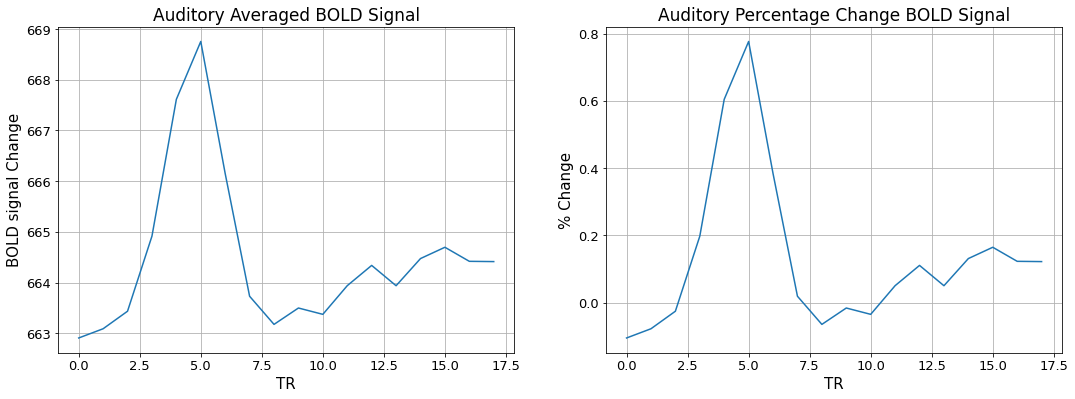

In [15]:
plot(ad_roi_total, 'Auditory')

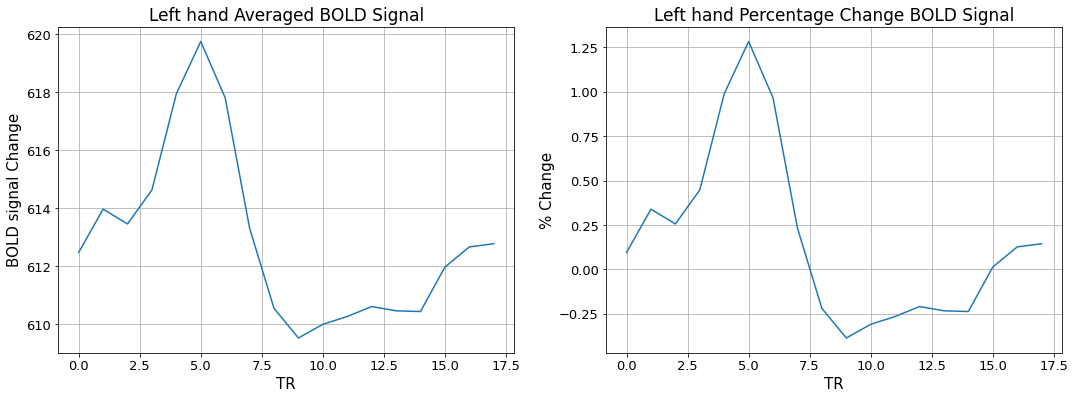

In [35]:
plot(lh_roi_total, 'left hand')

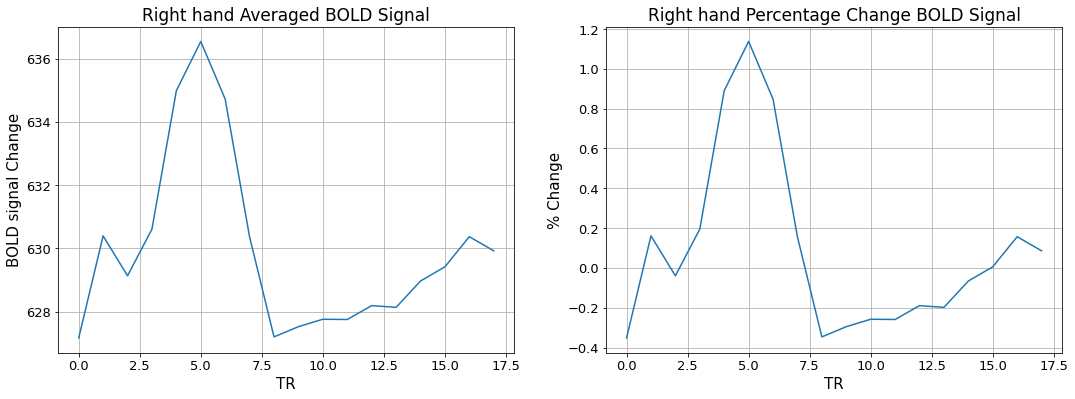

In [36]:
plot(rh_roi_total, 'right hand')

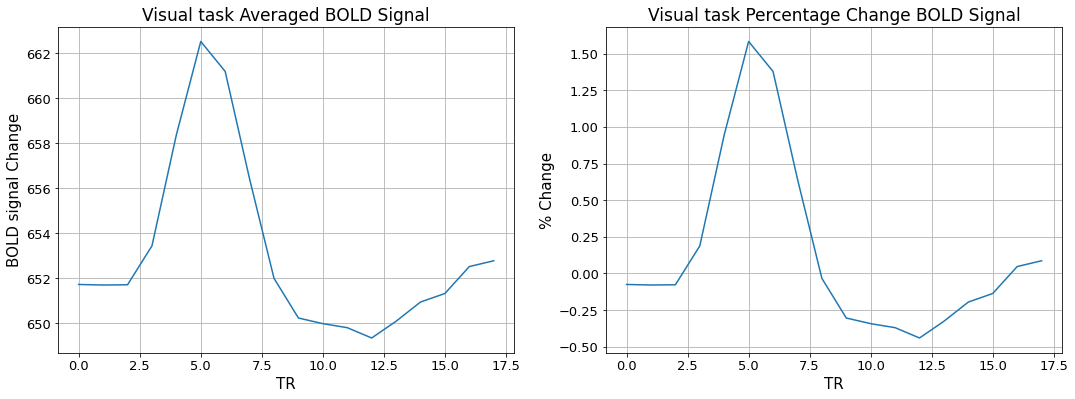

In [37]:
plot(vs_roi_total, 'visual task')

## Deconvolution

When $B(t) = \int_{0}^{t}N(t)*h(t-\tau)d\tau$, we can use Fast Fourier Transform to get h(t) since convolution turns into product of two argument functions. So we can write ...   
$h(t) = IFFT(\frac{FFT(B(t))}{FFT(N(t)})$

Do this with boxcar on TR 10, 11 and rest 0 for 18 ~ 52sec(9 ~ 26 only)

In [18]:
n = np.array(
    [0 for _ in range(0, 10)] +
    [1 for _ in range(10, 14)] +
    [0 for _ in range(14, 30)]
)

In [19]:
def deconvolution(bold, boxcar=None):
    
    if boxcar is None:
        boxcar = np.array(
            [0 for _ in range(0, 10)] +
            [1 for _ in range(10, 12)] +
            [0 for _ in range(12, 30)]
        )
        
    return np.fft.ifft(np.fft.fft(bold) / np.fft.fft(boxcar))

In [40]:
n = np.array(
    [0] + [1] * 2 + [0] * 15)

IndexError: index 18 is out of bounds for axis 0 with size 18

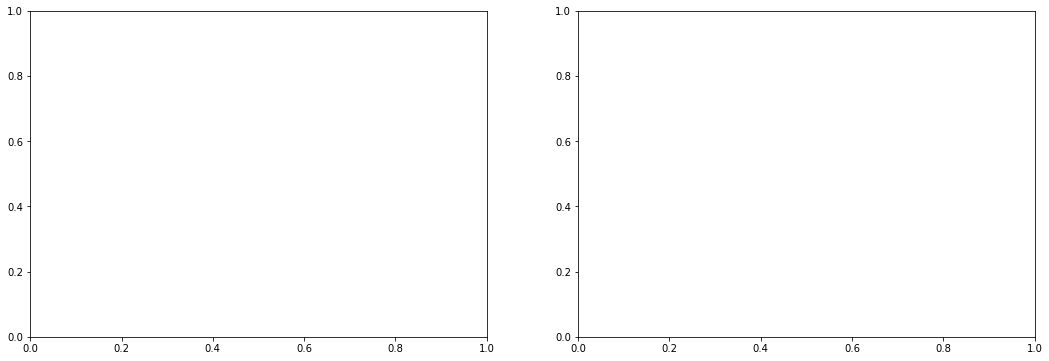

In [41]:
plot(deconvolution(ad_roi_total[task_related_tmask], boxcar=n).real, 'Auditory', 'HRF')

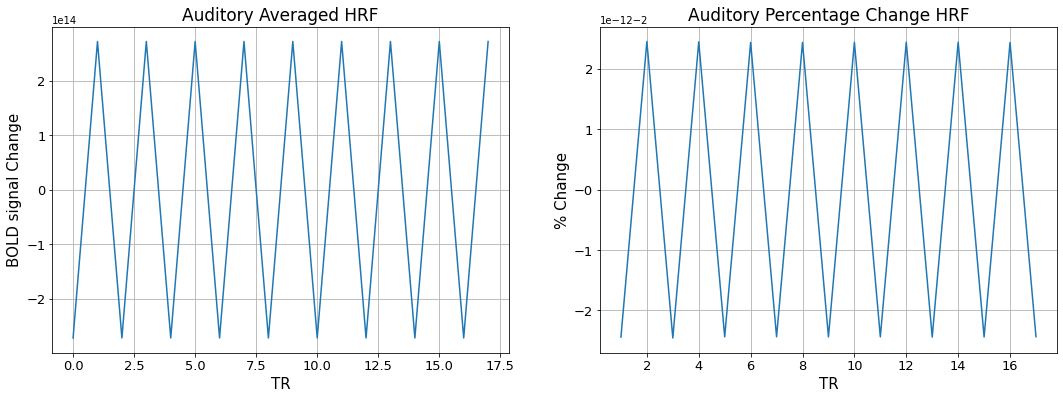

In [24]:
plot(deconvolution(ad_roi_total[task_related_tmask], boxcar=n).real, 'Auditory', 'HRF')

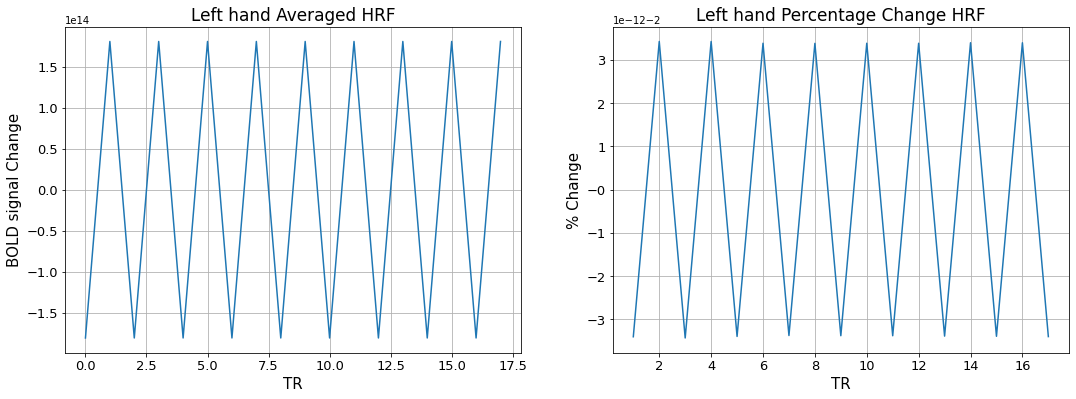

In [25]:
plot(deconvolution(lh_roi_total[task_related_tmask], boxcar=n).real, 'Left hand', 'HRF')

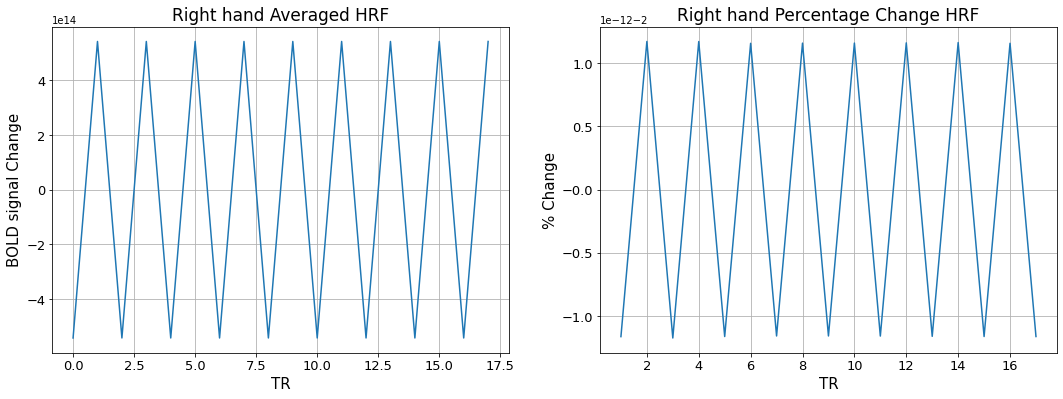

In [26]:
plot(deconvolution(rh_roi_total[task_related_tmask], boxcar=n).real, 'right hand', 'HRF')

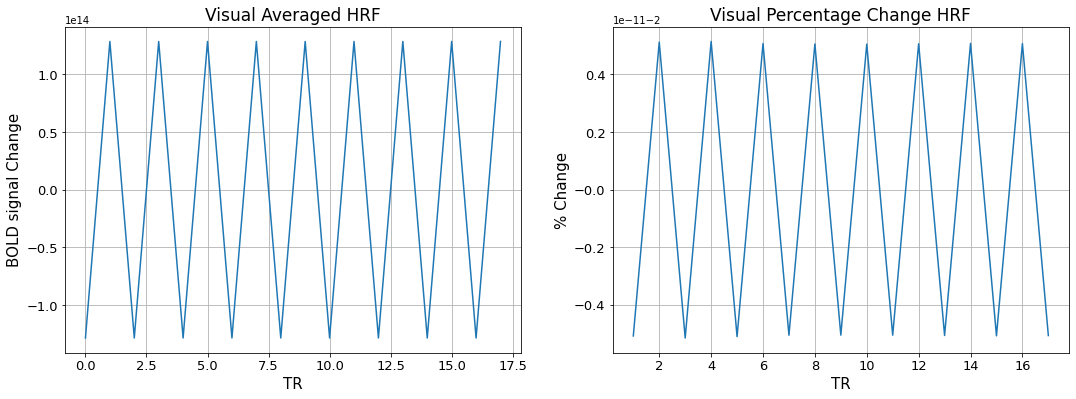

In [27]:
plot(deconvolution(vs_roi_total[task_related_tmask], boxcar=n).real, 'visual', 'HRF')

## Gamma by myself

Gamma function defined as follows   
$h(t) = \frac{(t-T_0) ^{n-1}}{\lambda ^n (n-1)!}e^{-t/\lambda}$ for $t > T_0$

In [26]:
fact = math.factorial

In [27]:
def one_gamma(t, t0, n, lamb):
    
    t[t < t0] = 0
    return (t - t0)**(n-1) / (lamb**n * fact(n-1)) * np.exp(-t/lamb)

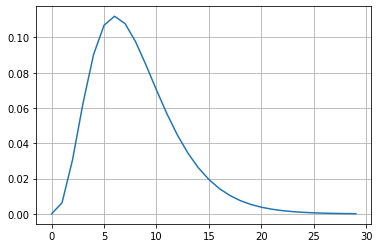

In [31]:
plt.plot(one_gamma(np.arange(0, 30), 0, 4, 2))
plt.grid()

In [29]:
def two_gamma(t, n1, n2, lamb1, lamb2, a, t0=0):
    
    t[t < t0] = 0
    C = sum(t**(n1-1)/(lamb1**n1 * fact(n1-1))*np.exp(-t/lamb1) - a * t**(n2-1)/(lamb2**n2 * fact(n2-1))*np.exp(-t/lamb2))
    return (t**(n1-1)/(lamb1**n1 * fact(n1-1))*np.exp(-t/lamb1) - a * t**(n2-1)/(lamb2**n2 * fact(n2-1))*np.exp(-t/lamb2)) / C

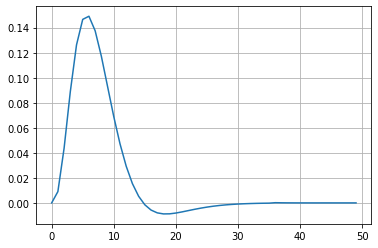

In [32]:
plt.plot(two_gamma(np.arange(0, 50), a=.3, n1=4, lamb1=2, n2=7, lamb2=2))
plt.grid()

### from nistats.hrf

In [170]:
# from nistats.hemodynamic_models import *
# plt.plot(spm_hrf(2, time_length=60))
# plt.plot(glover_hrf(2, time_length=60, onset=1))
# plt.plot(glover_hrf(2, time_length=60, onset=10))
# make_first_level_design_matrix((0, 2))

## Fit?

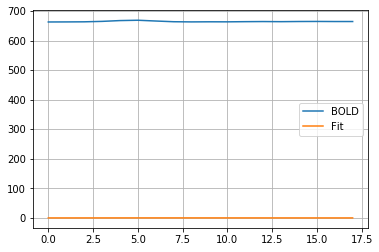

In [33]:
C = sum(ad_roi_total[task_related_tmask])
plt.plot(ad_roi_total[task_related_tmask],
         label='BOLD')
plt.plot(one_gamma(np.arange(0, 18), 0, 4, 2), label='Fit')
plt.grid()
plt.legend()

## Least Square Algorithm

### Grid Search

#### Define SSE

In [65]:
SSE = lambda true, pred: sum(np.square(true - pred)) / len(true)

In [66]:
from itertools import product

def cases(cases: dict):
    
    combinations = product(*params_one.values())
    return list(combinations)

#### One-Gamma
params: onset(T0), n, lambda

In [110]:
params_one = {
    'T0': [0],
    'n' : [i * .01 for i in range(200, 400)],
    'l' : [i * .001 for i in range(1000, 2000)]
}

cases_one = cases(params_one)

In [111]:
reference = (sum(ad_roi_total[0:10]) + sum(ad_roi_total[20:])) / 20
true = percentage(ad_roi_total, reference)[task_related_tmask]
losses = []
for case in cases_one:
    
    pred = one_gamma_given(case)
    losses.append(SSE(true, pred))
    
#     plt.plot(pred)
#     plt.show()
#     clear_output(wait=True)
    
losses.index(min(losses))

21609

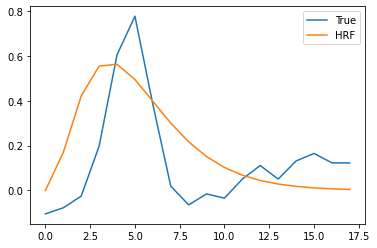

In [112]:
plt.plot(true, label='True')
plt.plot(one_gamma_given(cases_one[losses.index(min(losses))]), label='HRF')
plt.grid()
plt.legend()

In [113]:
cases_one[21609], min(losses)

((0, 2.21, 1.609), 0.041857416634406855)

In [109]:
cases_one[209994], min(losses)

((0, 2.2, 1.6), 0.041870188673261775)

#### Two-Gamma
params: onset(T0), n1, lambda1, n2, lambda2

### Gradient Descent Trials

In [34]:
import numpy as np
import math
fact = math.factorial
math.gamma

<function math.gamma(x, /)>

In [19]:
def one_gamma_given(params: list):
    
    t0, n, lamb = params
    t = np.arange(0, 18)
    return (t - t0)**n / (lamb**n * math.gamma(n)) * np.exp(-t/lamb)

In [100]:
def partial_difference_quotient(func, v, i, h=1e-9):
    
    w = [v_j + (h if j==i else 0) for j, v_j in enumerate(v)]
    return (func(w) - func(v)) / h

In [101]:
def gradient_estimate(func, v, h=1e-9):
    
    return [partial_difference_quotient(func, v, i, h) for i, _ in enumerate(v)]

In [ ]:
init_params = (0, 4, 2)

In [28]:
gradient_estimate(one_gamma_given, (0, 4, 2))

[array([ 1.04166667e-27, -3.79072185e-02, -7.35749685e-01, -3.38876107e+00,
        -8.66140399e+00, -1.60321461e+01, -2.41964144e+01, -3.17203507e+01,
        -3.75103112e+01, -4.09983322e+01, -4.21120635e+01, -4.11360707e+01,
        -3.85494735e+01, -3.48884609e+01, -3.06519457e+01, -2.62498590e+01,
        -2.19848444e+01, -1.80559727e+01]),
 array([ 0.00000000e+00, -1.23153983e-02,  8.03172199e-01,  1.07270657e+01,
         4.90773541e+01,  1.36022782e+02,  2.79602003e+02,  4.70635604e+02,
         6.86387380e+02,  8.98589152e+02,  1.08129702e+03,  1.21604254e+03,
         1.29374547e+03,  1.31406211e+03,  1.28325651e+03,  1.21158836e+03,
         1.11090294e+03,  9.92778429e+02]),
 array([ 0.00000000e+00, -1.10564280e-02, -3.67876069e-01, -2.11797796e+00,
        -5.77427655e+00, -1.00201206e+01, -1.20982879e+01, -9.25192920e+00,
        -2.50068410e-04,  1.53740521e+01,  3.50930353e+01,  5.65617780e+01,
         7.70987222e+01,  9.44895035e+01,  1.07281912e+02,  1.14843427e+02,


In [105]:
def one_gamma_loss(params):
    
    true = ad_roi_total[task_related_tmask] / sum(ad_roi_total[task_related_tmask])
    pred = one_gamma_given(params)
    return np.sum(np.square(true - pred)) / len(true)

In [106]:
gradient_estimate(one_gamma_loss, [0, 4, 2])

[-0.21801535576848607, 0.07952666303268074, 0.09412015611331981]

In [108]:
init_params = np.array([0, 4, 2])
params = init_params

true = ad_roi_total[task_related_tmask] / sum(ad_roi_total[task_related_tmask])
pred = one_gamma_given(init_params)

lr = 1e-10
for i in range(10):
    print(f'{i} th EPOCHS')
    
    pred = one_gamma_given(params)
    loss = SSE(true, pred)
    print(f'Prediction:: {pred} | LOSS:: {loss}')
    
    grads = list(map(lambda x: x * lr, gradient_estimate(one_gamma_loss, params)))
    print(f'Gradient:: {grads}')
    params = grads

0 th EPOCHS
Prediction:: [0.         0.00631803 0.06131324 0.18826607 0.36089409 0.53440754
 0.67212542 0.75524914 0.78146726 0.75923048 0.70186948 0.62327521
 0.53541047 0.44728882 0.36490477 0.29166559 0.22900915 0.1770196 ] | LOSS:: nan
Gradient:: [-2.1801535576848607e-11, 7.952666303268074e-12, 9.412015611331982e-12]
1 th EPOCHS
Prediction:: [7.9526663e-12 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00] | LOSS:: 0.2357021060747453
Gradient:: [nan, -6.158113515647434e-13, 0.0]
2 th EPOCHS
Prediction:: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] | LOSS:: nan
Gradient:: [nan, nan, nan]
3 th EPOCHS
Prediction:: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] | LOSS:: nan
Gradient:: [nan, nan, nan]
4 th EPOCHS
Prediction:: [nan nan nan nan n

<ipython-input-45-ab107456a299>:1: RuntimeWarning: invalid value encountered in sqrt
  SSE = lambda t, p: np.sum(np.sqrt(t - p)) / len(t)
<ipython-input-94-f88361b1c83b>:5: RuntimeWarning: invalid value encountered in power
  return (t - t0)**n / (lamb**n * math.gamma(n)) * np.exp(-t/lamb)
<ipython-input-94-f88361b1c83b>:5: RuntimeWarning: divide by zero encountered in double_scalars
  return (t - t0)**n / (lamb**n * math.gamma(n)) * np.exp(-t/lamb)
<ipython-input-94-f88361b1c83b>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (t - t0)**n / (lamb**n * math.gamma(n)) * np.exp(-t/lamb)
<ipython-input-94-f88361b1c83b>:5: RuntimeWarning: invalid value encountered in true_divide
  return (t - t0)**n / (lamb**n * math.gamma(n)) * np.exp(-t/lamb)


In [63]:
grads

[nan, nan, nan]

In [56]:
params

[nan, nan, nan]

In [110]:
pred = one_gamma_given(init_params)

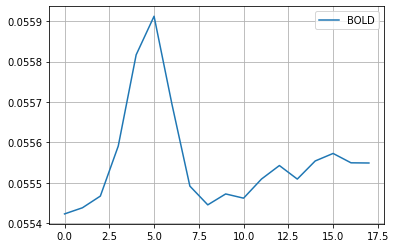

In [117]:
plt.plot(true, label='BOLD')
plt.plot(pred, label='HRF Pred')
plt.legend()
plt.grid()

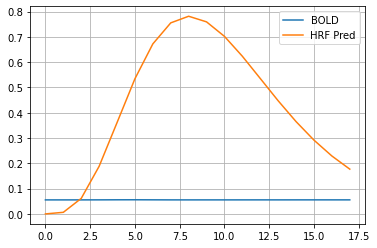

In [118]:
plt.plot(true, label='BOLD')
plt.plot(pred, label='HRF Pred')
plt.legend()
plt.grid()